<a href="https://colab.research.google.com/github/AmirHoseein99/Movie_Writer/blob/master/MoviePlotGen_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional, Input

In [2]:
dataset_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MoviePlotGenerator/wiki_movie_plots_deduped.csv.zip")
dataset_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
dataset_df = dataset_df[dataset_df["Genre"] != "unknown"]
dataset_df.shape

(28803, 8)

In [ ]:
drama_movie_plot = dataset_df[dataset_df["Genre"] == "drama"]
drama_movie_plot.shape

(5964, 8)

In [ ]:
drama_movie_plot = dataset_df[(dataset_df["Genre"] == "drama") & (dataset_df["Release Year"] >= 2000)]
drama_movie_plot.shape

(1675, 8)

# **Using Words to Generate the plot**

In [3]:
drama_movie_plot = dataset_df[(dataset_df["Genre"] == "drama") & (dataset_df["Release Year"] >= 2000)].Plot.to_numpy()
print("uesd dataset shape : ", drama_movie_plot.shape)
drama_movie_plot[0]

uesd dataset shape :  (1675,)


"Gwen Cummings (Sandra Bullock) spends her nights in a drunken haze with her boyfriend, Jasper (Dominic West). She ruins her sister (Elizabeth Perkins) Lily's wedding by showing up late and disheveled, delivering a drunken, rambling speech, and knocking over the wedding cake. Intoxicated, Gwen steals a limousine from the reception, tries to locate a cake store, and winds up losing control of the car and crashing into a house. She is given a choice between 28 days in jail or in a rehab center, and she chooses rehab.\r\nGwen is introduced to a variety of patients while in treatment: Oliver (Mike O'Malley) (a hypersexual cocaine addict), Daniel (Reni Santoni) and Roshanda (Marianne Jean-Baptiste) (alcoholics), Bobbi Jean (Diane Ladd) (an older addict), Gerhardt (Alan Tudyk) (a gay man whose addiction is not specified), and Cornell (Steve Buscemi), the rehab facility's director (a recovered drug addict and alcoholic). Her roommate is young Andrea (Azura Skye), a heroin addict who sporadica

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(drama_movie_plot)
vocab_size = len(tokenizer.word_index)
drama_movie_plot_seq = tokenizer.texts_to_sequences(drama_movie_plot)
print("number of unique Tokens : ", len(tokenizer.word_index))

number of unique Tokens :  33130


In [ ]:
plot_tokens = [token for plot in drama_movie_plot_seq for token in  plot]

In [ ]:
tokenizer.sequences_to_texts([drama_movie_plot_seq[0][:26]])

["gwen cummings sandra bullock spends her nights in a drunken haze with her boyfriend jasper dominic west she ruins her sister elizabeth perkins lily's wedding by"]

In [ ]:
train_seq_len = 25
seq_len = train_seq_len + 1
text_sequences = []
for i in range(seq_len, len(tokenizer.word_index)):
    # Construct sequence.
    seq = plot_tokens[i - seq_len: i]
    # Append.
    text_sequences.append(seq)
text_sequences = np.array(text_sequences)
print('all sequences shape : ', text_sequences.shape)

all sequences shape :  (33104, 26)


In [ ]:
print("first sequence len : ", len(tokenizer.sequences_to_texts([text_sequences[0]])[0].split(" ")))
print("first sequence train tokens: ", tokenizer.sequences_to_texts([text_sequences[0]])[0].split(" ")[:-1])
print("first sequence traget tokens: ", tokenizer.sequences_to_texts([text_sequences[0]])[0].split(" ")[-1])

first sequence len :  26
first sequence train tokens:  ['gwen', 'cummings', 'sandra', 'bullock', 'spends', 'her', 'nights', 'in', 'a', 'drunken', 'haze', 'with', 'her', 'boyfriend', 'jasper', 'dominic', 'west', 'she', 'ruins', 'her', 'sister', 'elizabeth', 'perkins', "lily's", 'wedding']
first sequence traget tokens:  by


In [ ]:
X, y = np.array(text_sequences[:, :-1]), np.array(text_sequences[:, -1])
print("train X shape is :", X.shape)
print("train y shape is :", y.shape)

train X shape is : (33104, 25)
train y shape is : (33104,)


In [ ]:

y = to_categorical(y, num_classes=(vocab_size + 1))
print("train y shape after transform :", y.shape)

train y shape after transform : (33104, 33131)


In [ ]:

input_layer = Input(shape=(train_seq_len))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=16, input_length=train_seq_len)(input_layer)
bi_gru_1 = Bidirectional(GRU(8, return_sequences=True))(embedding_layer)
bi_gru_2 = Bidirectional(GRU(8))(bi_gru_1)

dense_1 = Dense(32, activation="elu")(bi_gru_2)
dense__output = Dense(units=vocab_size+1, activation="softmax")(dense_1)
gru_model = keras.Model(input_layer, dense__output)

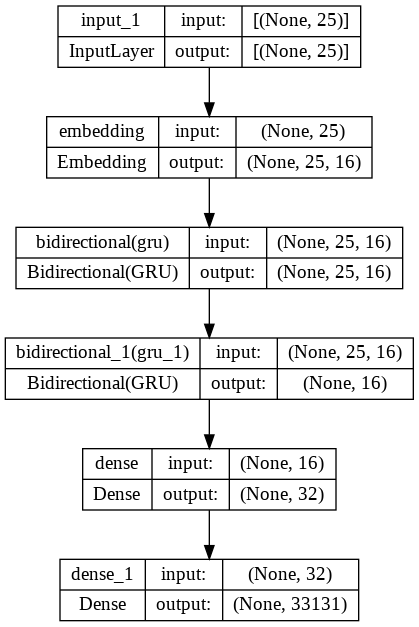

In [ ]:
plot_model(gru_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 180
batch_size = 32
callbacks = [

    keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="accuracy", patience=50, verbose=1),
]

In [ ]:
gru_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)

history = gru_model.fit(
    X, y, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=1)

In [ ]:

pickle.dump(tokenizer, open('/content/drive/MyDrive/Colab Notebooks/MoviePlotGenerator/tokenizer', 'wb'))
gru_model.save('/content/drive/MyDrive/Colab Notebooks/MoviePlotGenerator/gru_model.h5')

In [12]:

gru_model = load_model ('/content/drive/MyDrive/Colab Notebooks/MoviePlotGenerator/gru_model.h5')
with open('/content/drive/MyDrive/Colab Notebooks/MoviePlotGenerator/tokenizer', 'rb') as pickle_file:
    tokenizer = pickle.load(pickle_file)

In [33]:


def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    
    for i in range(num_gen_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        pred_word_ind =np.argmax( model.predict(pad_encoded, verbose=0))
        pred_word = tokenizer.index_word[pred_word_ind]
        input_text += ' ' + pred_word
        output_text.append(pred_word)
        
    return ' '.join(output_text)

In [25]:
sample_text = drama_movie_plot[0].split(" ")[:25]
print(' '.join(sample_text))

Gwen Cummings (Sandra Bullock) spends her nights in a drunken haze with her boyfriend, Jasper (Dominic West). She ruins her sister (Elizabeth Perkins) Lily's wedding


In [34]:
generated_text = generate_text(model=gru_model, 
                               tokenizer=tokenizer,
                               seq_len=25, 
                               seed_text=sample_text, 
                               num_gen_words=40)
print(generated_text)

home that two and are friend engage relationship and the game teams sessions is 10 it were of gives fielding that end the game girls him she buddy loves years short who was flight way colonel her in and execution


# **Using Characters to Generate the plot**